In [95]:
import pandas as pd
import numpy as np 
import string
from scipy import sparse


from sklearn import preprocessing
from sklearn.feature_extraction import text 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



In [76]:
data = pd.read_csv('./data/smsspamcollection/SMSSpamCollection.txt', sep='\t')
data.columns=['label', 'sms']

le = preprocessing.LabelEncoder()
data['target'] = le.fit_transform(data['label'])

data = data[['sms', 'target']]

chars = set(string.punctuation)
# print(chars)
data.sms = data.sms.apply(lambda x: ''.join(char for char in x if x not in chars ))

print(len(data), data.target.value_counts())
data.head()

5571 0    4824
1     747
Name: target, dtype: int64


,sms,target
0,Ok lar... Joking wif u oni...,0
1,Free entry in 2 a wkly comp to win FA Cup fina...,1
2,U dun say so early hor... U c already then say...,0
3,"Nah I don't think he goes to usf, he lives aro...",0
4,FreeMsg Hey there darling it's been 3 week's n...,1


In [107]:
x_train, x_test, y_train, y_test = train_test_split(data.sms, data.target, test_size=.2)

word_vectorizer = text.TfidfVectorizer(max_features=20000, stop_words='english', analyzer='word', lowercase=True,
                                  ngram_range=(1,3) ,dtype=np.float32)
char_vectorizer = text.TfidfVectorizer(max_features=40000, stop_words='english', analyzer='char', lowercase=True,
                                  ngram_range=(3,6) ,dtype=np.float32)


w_x_train = word_vectorizer.fit_transform(x_train)
c_x_train = char_vectorizer.fit_transform(x_train)

w_x_test = word_vectorizer.transform(x_test)
c_x_test = char_vectorizer.transform(x_test)



# word_vectorizer.inverse_transform(w_x_train[0])
# char_vectorizer.inverse_transform(c_x_train[0])



In [121]:
# train_vec = sparse.hstack([w_x_train, c_x_train])
# test_vec = sparse.hstack([w_x_test, c_x_test])

train_vec = np.hstack((w_x_train, c_x_train))
test_vec = np.hstack((w_x_test, c_x_test))

print(w_x_train.shape,c_x_train.shape, train_vec.shape)


model = LogisticRegression(C=2, class_weight='balanced')
model.fit(c_x_train, y_train)

yhat = model.predict(c_x_test)

print(classification_report(y_test, yhat))

(4456, 20000) (4456, 40000) (2,)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       956
           1       0.98      0.94      0.96       159

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 100, 100)          2000000   
_________________________________________________________________
flatten_16 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 33        
Total params: 2,320,065
Trainable params: 2,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
140/140 [==============================] - 3s 15ms/step - loss: 0.3097 - acc: 0.8654
Epoch 2/6
140/140 [==============================] - 2s 18ms/step - loss: 0.1078 - acc: 0.9877
Epoch 3/6
140/140 [==============================] 

(array([982.,   6.,   2., 125.]),
 array([1.3923904e-08, 1.6292207e-01, 3.2584411e-01, 4.8876616e-01,
        6.5168822e-01], dtype=float32),
 <BarContainer object of 4 artists>)

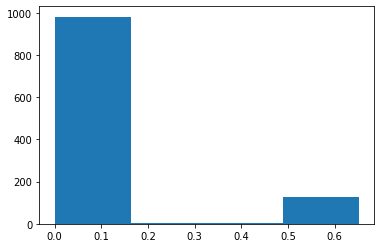

In [202]:
from keras import preprocessing 
from keras.models import Sequential
from keras.layers import Embedding,Flatten , Dense, LSTM
import matplotlib.pyplot as plt

tokenizer = preprocessing.text.Tokenizer(num_words=20000, oov_token =  '<OOV>')
tokenizer.fit_on_texts(data.sms)
sequences = tokenizer.texts_to_sequences(data.sms)

# lens = plt.hist([len(x) for x in sequences])

pad_sequences = preprocessing.sequence.pad_sequences(sequences, maxlen=100, padding='post')


x_train, x_test, y_train, y_test = train_test_split(pad_sequences, data.target, test_size=.2)


model = Sequential()
model.add(Embedding(20000, 100, input_length=100))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()


model.fit(x_train, y_train, epochs=6)


prob = model.predict(x_test)
yhat = np.where(prob > 0.5, 1, 0)


print(classification_report(y_test, yhat))

plt.hist(prob, bins=4)

[0 1]


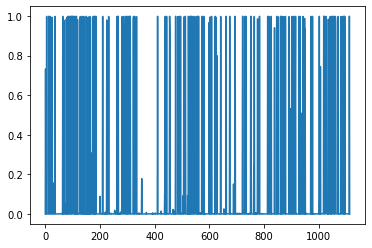

In [201]:
yhat = np.where(prob > 0.5, 1, 0)

print(np.unique(yhat))
plt.plot(prob)
# print([1  for x in prob if x>0.5 else ])